# What drives the price of a car?


**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

- My data problem definition is determining if I am able to implement a model to predict accurately the price of a used car. The task will be to develop a regression model to estimate the sale price of a used car based on its features.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

- First I would load the dataset, look at the first few rows and look at the data tpyes
- Then I would check for null values and decide what to do with them depending on how many there are, if they are relevant to my analysis
- After that I would look at some basic visualizations to see what kinds of trends I notice in the data by eye to determine if there are obvious factors to look more deeply into 

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [1]:
#importing libs 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, RFE


In [2]:
#loading the data
cars = pd.read_csv('data/vehicles.csv')

#looking at the structure by choosing 5 random rows to look at
cars.sample(5)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
194659,7302162813,ann arbor,32000,2017.0,dodge,caravan,excellent,8 cylinders,gas,54000.0,clean,automatic,NaN,fwd,mid-size,mini-van,black,mi
144658,7313809258,rockford,0,2002.0,gmc,envoy xl,excellent,6 cylinders,gas,144199.0,clean,automatic,1GKET16S326117782,4wd,NaN,SUV,black,il
266382,7316686362,buffalo,5200,2006.0,buick,ranier,NaN,NaN,gas,184000.0,clean,automatic,NaN,NaN,NaN,NaN,NaN,ny
300078,7309726398,lima / findlay,7500,2014.0,chrysler,200,good,6 cylinders,gas,84200.0,clean,automatic,NaN,fwd,NaN,NaN,black,oh
331417,7312961495,lehigh valley,4900,2004.0,buick,lesabre customsedan,excellent,6 cylinders,gas,98174.0,NaN,automatic,1G4HP52K344120573,NaN,NaN,other,NaN,pa


In [3]:
#exploring dataset
cars.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN',
       'drive', 'size', 'type', 'paint_color', 'state'],
      dtype='object')

In [4]:
#dropping columns that do not relate to price - I'm also dropping region since there is also state 
cars1 = cars.drop(columns = ['id','VIN','region'])
cars1.sample(5)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
290372,13450,2013.0,honda,crv ex-l awd,excellent,4 cylinders,gas,115000.0,rebuilt,automatic,4wd,mid-size,SUV,blue,oh
380677,4995,2010.0,kia,soul,NaN,NaN,gas,177497.0,clean,automatic,NaN,NaN,wagon,black,tx
234067,2000,2004.0,kia,amanti base 4dr sedan,good,NaN,gas,204000.0,clean,manual,NaN,NaN,sedan,blue,nc
96160,20995,2010.0,jeep,wrangler,NaN,NaN,gas,61295.0,clean,automatic,4wd,NaN,SUV,white,fl
91978,40990,2017.0,mercedes-benz,gls 450 sport,good,6 cylinders,gas,43451.0,clean,other,NaN,NaN,SUV,NaN,de


In [5]:
#looking at data type
cars1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   cylinders     249202 non-null  object 
 6   fuel          423867 non-null  object 
 7   odometer      422480 non-null  float64
 8   title_status  418638 non-null  object 
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
 14  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 48.9+ MB


In [6]:
#converting objects to closest data type
cars3 = cars1.convert_dtypes()

In [7]:
#looking at data type after conversion
cars3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         426880 non-null  Int64 
 1   year          425675 non-null  Int64 
 2   manufacturer  409234 non-null  string
 3   model         421603 non-null  string
 4   condition     252776 non-null  string
 5   cylinders     249202 non-null  string
 6   fuel          423867 non-null  string
 7   odometer      422480 non-null  Int64 
 8   title_status  418638 non-null  string
 9   transmission  424324 non-null  string
 10  drive         296313 non-null  string
 11  size          120519 non-null  string
 12  type          334022 non-null  string
 13  paint_color   296677 non-null  string
 14  state         426880 non-null  string
dtypes: Int64(3), string(12)
memory usage: 50.1 MB


In [8]:
#looking at sum of nulls for each variable
cars3.isnull().sum()

price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64

In [9]:
#looking into statistics for numeric and categorical variables
cars3.describe(include = ['string'])

,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
count,409234,421603,252776,249202,423867,418638,424324,296313,120519,334022,296677,426880
unique,42,29649,6,8,5,6,3,3,4,13,12,51
top,ford,f-150,good,6 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,ca
freq,70985,8009,121456,94169,356209,405117,336524,131904,63465,87056,79285,50614


In [10]:
# check number of records where the value is equal to 0
cars3.eq(0).sum()

price           32895
year                0
manufacturer        0
model               0
condition           0
cylinders           0
fuel                0
odometer         1965
title_status        0
transmission        0
drive               0
size                0
type                0
paint_color         0
state               0
dtype: int64

<Axes: >

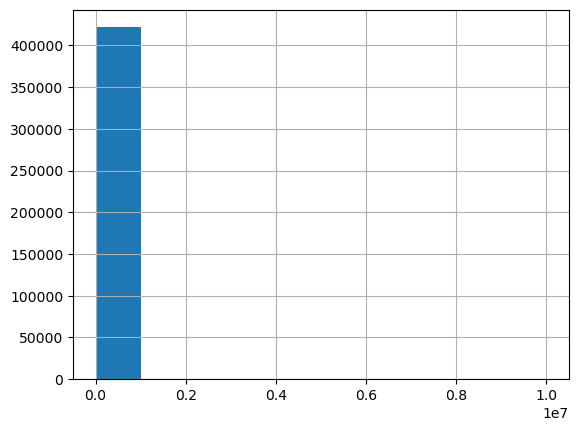

In [11]:
#looking at distribution of odometer values
cars3.odometer.hist()

In [12]:
#looking at average odometer reading
statistics.mode(cars3.odometer)

<NA>

<Axes: >

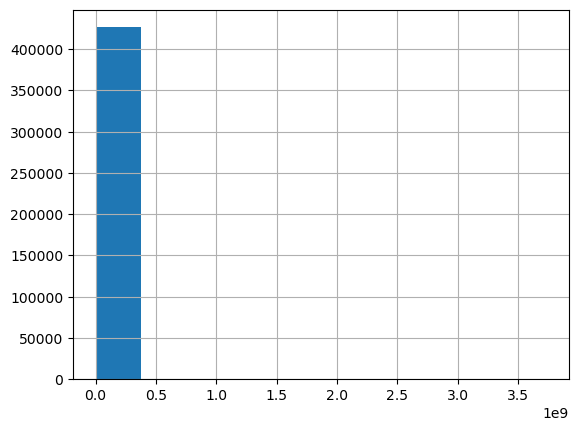

In [13]:
#looking at distribution of price values
cars3.price.hist()

In [14]:
#looking at avg car price 
statistics.mode(cars3.price)

0

- I think it's most likely that the entrires with 0 for price and odometer are erroneous

In [15]:
#dropping rows where 'odometer' or 'price' is 0
cars5 = cars3[(cars3['odometer'] != 0) & (cars3['price'] != 0)]
cars5.sample(5)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
113013,8990,2014,volkswagen,passat,<NA>,<NA>,gas,62000,clean,automatic,<NA>,<NA>,sedan,<NA>,fl
353285,25999,2016,jeep,grand cherokee,<NA>,6 cylinders,gas,89329,clean,automatic,<NA>,<NA>,SUV,red,tn
420944,17995,2012,ram,1500,excellent,8 cylinders,gas,134901,clean,automatic,4wd,full-size,truck,grey,wi
231351,39590,2017,chevrolet,camaro ss coupe 2d,good,8 cylinders,gas,10496,clean,other,rwd,<NA>,coupe,white,nc
117503,7895,2015,dodge,dart se,like new,<NA>,gas,73768,clean,manual,fwd,<NA>,sedan,red,fl


In [16]:
#looking into statistics for numeric and categorical variables
cars5.describe(include = ['string'])

,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state
count,374714,385965,240504,231815,388295,383368,389061,271277,110423,305431,274961,390581
unique,42,27975,6,8,5,6,3,3,4,13,12,51
top,ford,f-150,good,6 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,ca
freq,64346,7026,118920,88239,327553,370016,304011,119631,58187,79555,72355,44173


In [17]:
cars5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 390581 entries, 27 to 426879
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         390581 non-null  Int64 
 1   year          389482 non-null  Int64 
 2   manufacturer  374714 non-null  string
 3   model         385965 non-null  string
 4   condition     240504 non-null  string
 5   cylinders     231815 non-null  string
 6   fuel          388295 non-null  string
 7   odometer      390581 non-null  Int64 
 8   title_status  383368 non-null  string
 9   transmission  389061 non-null  string
 10  drive         271277 non-null  string
 11  size          110423 non-null  string
 12  type          305431 non-null  string
 13  paint_color   274961 non-null  string
 14  state         390581 non-null  string
dtypes: Int64(3), string(12)
memory usage: 48.8 MB


In [18]:
# Going to impute numeric missing values using KNNImputer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer
numeric_columns = cars5.select_dtypes(include=['int64']).columns
numeric_data = cars5[numeric_columns]

imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(numeric_data)
imputed_df = pd.DataFrame(imputed_data, columns=numeric_columns)

#reset index to ensure alignment
imputed_df.reset_index(drop=True, inplace=True)

# Drop original numeric columns from cars5 and reset index
df_non_numeric = cars5.drop(columns=numeric_columns).reset_index(drop=True)

#merge the imputed data back, ensuring alignment
cars_imputed = pd.concat([df_non_numeric, imputed_df], axis=1)


In [19]:
cars_imputed.sample(5)

,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state,price,year,odometer
121080,bmw,528i,like new,4 cylinders,gas,clean,automatic,rwd,<NA>,<NA>,silver,id,13500.0,2012.0,81000.0
158269,toyota,tacoma,excellent,4 cylinders,gas,clean,other,4wd,full-size,truck,blue,ky,16795.0,2009.0,152696.0
165815,toyota,tundra double cab sr,good,8 cylinders,gas,clean,other,<NA>,<NA>,pickup,red,md,30990.0,2017.0,41124.0
293126,chevrolet,spark,excellent,4 cylinders,gas,clean,automatic,fwd,sub-compact,sedan,silver,or,8999.0,2014.0,42006.0
77845,volvo,xc60,<NA>,<NA>,gas,clean,automatic,<NA>,<NA>,<NA>,<NA>,ct,12995.0,2013.0,119000.0


In [20]:
#looking at sum of nulls for each variable
cars_imputed.isnull().sum()

manufacturer     15867
model             4616
condition       150077
cylinders       158766
fuel              2286
title_status      7213
transmission      1520
drive           119304
size            280158
type             85150
paint_color     115620
state                0
price                0
year                 0
odometer             0
dtype: int64

In [21]:
#setting up target variable
X = cars_imputed.drop('price', axis=1)
y = cars_imputed['price']

In [22]:
#setting up test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

- First, I am going to setup a preprocessor for my pipeline to scale the numerical data and encode the categorical columns

In [23]:
#indicating columns as numeric or categorical
categorical_columns = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 
                       'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
numerical_columns = ['year', 'odometer']

In [24]:
#using targetencoder for categorical columns 
#https://contrib.scikit-learn.org/category_encoders/targetencoder.html
#setting up preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', StandardScaler(), numerical_columns),
        ('categorical', TargetEncoder(), categorical_columns)
    ])


In [25]:
#setting up linear regression model
lrmodel = LinearRegression()

In [26]:
#setting up the pipeline
lrpipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', lrmodel)
])

# Fit the pipeline
lrpipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['year', 'odometer']),
                                                 ('categorical',
                                                  TargetEncoder(),
                                                  ['manufacturer', 'model',
                                                   'condition', 'cylinders',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state'])])),
                ('regressor', LinearRegression())])

In [27]:
#making predictions from pipeline for linear regression
lr_y_pred = lrpipeline.predict(X_test)

In [28]:
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_mse

147541199544510.2

- since that is a very high MSE, I am going to add some complexity to my linear regression model and see if I can make it more effective
- Linear regression model with polynomial features and sequential feature selection is next

In [29]:
#setting up polynomial features and SFS
poly = PolynomialFeatures(degree=2, include_bias=False)

sfs = SequentialFeatureSelector(lrmodel, n_features_to_select=3, direction='forward')


In [30]:
#setting up pipeline
poly_sfs_lr_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', poly),
    ('sfs', sfs),
    ('model', lrmodel)
])


In [31]:
#fitting to training data
poly_sfs_lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['year', 'odometer']),
                                                 ('categorical',
                                                  TargetEncoder(),
                                                  ['manufacturer', 'model',
                                                   'condition', 'cylinders',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('sfs',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           n_features_to_select=3)),
                ('model', LinearRegression())])

In [32]:
#predicting test
poly_sfs_lr_pred = poly_sfs_lr_pipe.predict(X_test)

In [33]:
#calculating MSE
poly_sfs_lr_mse = mean_squared_error(y_test, poly_sfs_lr_pred)
poly_sfs_lr_mse

145473450523713.7

- moving on to ridge models because I am still getting a very high MSE on linear models

In [34]:
#setting initial ridge model
ridge_model = Ridge(alpha=1.0)

In [35]:
sfsridge = SequentialFeatureSelector(estimator=Ridge(), n_features_to_select=3)

In [36]:
#setting up pipeline for ridge 
rige_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', poly),
    ('sfs', sfsridge),
    ('ridge', ridge_model)
])


In [37]:
#fitting to training data
rige_pipe.fit(X_train, y_train)

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.44716e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.88304e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.99777e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.07242e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.34244e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.52733e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.76845e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.00463e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['year', 'odometer']),
                                                 ('categorical',
                                                  TargetEncoder(),
                                                  ['manufacturer', 'model',
                                                   'condition', 'cylinders',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('sfs',
                 SequentialFeatureSelector(estimator=Ridge(),
                                           n_features_to_select=3)),
                ('ridge', Ridge())])

In [38]:
#predicting test
ridge_pred = rige_pipe.predict(X_test)

In [39]:
#calculating MSE
ridge_pred_mse = mean_squared_error(y_test, ridge_pred)
ridge_pred_mse

145473450523713.7

- Still a very high MSE so going to use ridge_cv to tune alpha parameter

In [40]:
#setting up pipeline for ridge CV

rigeCV_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', poly),
    ('sfs', sfsridge),
    ('ridgecv', RidgeCV(alphas=[0.1, 1.0, 10.0], store_cv_values=True))
])


In [41]:
#fitting to data 
rigeCV_pipe.fit(X_train,y_train)

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.44716e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.88304e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.99777e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.07242e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.34244e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.52733e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.76845e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.00463e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['year', 'odometer']),
                                                 ('categorical',
                                                  TargetEncoder(),
                                                  ['manufacturer', 'model',
                                                   'condition', 'cylinders',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('sfs',
                 SequentialFeatureSelector(estimator=Ridge(),
                                           n_features_to_select=3)),
                ('ridgecv',
                 RidgeCV(alphas=[0.1, 1.0, 10.0], store_cv_values=True))])

In [42]:
#predicting test
ridgeCV_pred = rigeCV_pipe.predict(X_test)

In [43]:
#calculating MSE
ridgeCV_pred_mse = mean_squared_error(y_test, ridgeCV_pred)
ridgeCV_pred_mse

6.1928336069207735e+38

In [44]:
#going to use TransformedTargetRegressor to try to enhance my predictions

log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

#adding ttr to pipeline
ttr_pipeline = TransformedTargetRegressor(regressor=rigeCV_pipe,
                                          transformer=log_transformer)

In [45]:
#fitting the TTR pipeline to data
ttr_pipeline.fit(X_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('numeric',
                                                                                       StandardScaler(),
                                                                                       ['year',
                                                                                        'odometer']),
                                                                                      ('categorical',
                                                                                       TargetEncoder(),
                                                                                       ['manufacturer',
                                                                                        'model',
                                                                                        'condition',
                                                                                        'cylinders',
                                                                                        'fuel',
                                                                                        'title_status',
                                                                                        'transmission',
                                                                                        'drive',
                                                                                        'size',
                                                                                        'type',
                                                                                        'paint_color',
                                                                                        'state'])])),
                                                     ('poly',
                                                      PolynomialFeatures(include_bias=False)),
                                                     ('sfs',
                                                      SequentialFeatureSelector(estimator=Ridge(),
                                                                                n_features_to_select=3)),
                                                     ('ridgecv',
                                                      RidgeCV(alphas=[0.1, 1.0,
                                                                      10.0],
                                                              store_cv_values=True))]),
                           transformer=FunctionTransformer(func=<ufunc 'log1p'>,
                                                           inverse_func=<ufunc 'expm1'>))

In [46]:
#predicting test
ttr_pred = ttr_pipeline.predict(X_test)

In [47]:
#calculating MSE
ttr_pred_mse = mean_squared_error(y_test, ttr_pred)
ttr_pred_mse

143214937529395.56

In [48]:
# Printing MSE values
print(f"Linear Regression MSE: {lr_mse}")
print(f"Polynomial + SFS Linear Regression MSE: {poly_sfs_lr_mse}")
print(f"Ridge Regression MSE: {ridge_pred_mse}")
print(f"RidgeCV Regression MSE: {ridgeCV_pred_mse}")
print(f"ttr Regression MSE: {ttr_pred_mse}")

Linear Regression MSE: 147541199544510.2
Polynomial + SFS Linear Regression MSE: 145473450523713.7
Ridge Regression MSE: 145473450523713.7
RidgeCV Regression MSE: 6.1928336069207735e+38
ttr Regression MSE: 143214937529395.56


- slight improvement using the ttr model

- looking at the MSEs, they are all still quite high. I am wondering if my data cleaning steps were not comprehensive enough. I want to redo my models on the data that just has all the null values dropped and I will compare my MSEs then
- It does appear that the more complex I make my model, the lower the MSE becomes indicating the ttr Regression is the best model so far

In [49]:
#dropping nulls from initial dataset instead of imputing
cars_dropped = cars5.dropna()
cars_dropped.sample(5)

,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
163148,23900,2015,ram,3500,excellent,8 cylinders,gas,147687,clean,automatic,4wd,full-size,truck,white,ia
265162,15980,2006,toyota,tundra double cab,excellent,8 cylinders,gas,86553,clean,automatic,4wd,full-size,pickup,silver,ny
238580,24900,2012,gmc,yukon,excellent,8 cylinders,gas,111000,clean,automatic,4wd,full-size,SUV,black,nc
388265,26288,2019,jeep,cherokee latitude plus,like new,6 cylinders,gas,47384,clean,automatic,4wd,mid-size,SUV,white,vt
89491,9970,2009,ford,f-150 4x4,good,8 cylinders,gas,167546,clean,automatic,4wd,full-size,pickup,white,dc


In [50]:
#setting up target variable for new data frame
Xdropped = cars_dropped.drop('price', axis=1)
ydropped = cars_dropped['price']

In [51]:
#setting up test train split
X_train1, X_test1, y_train1, y_test1 = train_test_split(Xdropped, ydropped, test_size=0.2, random_state=123)

In [52]:
#fitting the linear regression pipeline
lrpipeline.fit(X_train1, y_train1)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['year', 'odometer']),
                                                 ('categorical',
                                                  TargetEncoder(),
                                                  ['manufacturer', 'model',
                                                   'condition', 'cylinders',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state'])])),
                ('regressor', LinearRegression())])

In [53]:
#making predictions from pipeline for linear regression
lr_y_pred1 = lrpipeline.predict(X_test1)

In [54]:
lr_mse1 = mean_squared_error(y_test1, lr_y_pred1)
lr_mse1

3186899451497.912

In [55]:
#fitting to training data
poly_sfs_lr_pipe.fit(X_train1, y_train1)

#predicting test
poly_sfs_lr_pred1 = poly_sfs_lr_pipe.predict(X_test1)

#calculating MSE
poly_sfs_lr_mse1 = mean_squared_error(y_test1, poly_sfs_lr_pred1)
poly_sfs_lr_mse1

1032543981330.9312

In [56]:
#fitting ridge model to new null training data
rige_pipe.fit(X_train1, y_train1)

#predicting test
ridge_pred1 = rige_pipe.predict(X_test1)

#calculating MSE
ridge_pred_mse1 = mean_squared_error(y_test1, ridge_pred1)
ridge_pred_mse1

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.75709e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.32945e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.48554e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.97443e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.6877e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.06706e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.73564e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.28941e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.4548e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.30292e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.07948e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.02538e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.35797e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.60581e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.02715e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.59074e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.94916e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.38462e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.99274e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.02426e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.95065e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.6922e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.49219e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.04135e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.40037e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.76291e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.36898e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.99951e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.19105e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.05687e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.44125e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.70998e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.60005e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.09636e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.12239e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.04994e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.38075e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.25859e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.35471e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.59192e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.89112e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.80482e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.6624e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.23254e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.28996e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.1811e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.00236e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.4897e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverus

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.87412e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.93702e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.7692e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.56104e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.36581e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.3452e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.24797e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.86289e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.26199e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.18885e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.92011e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.26895e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.07616e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.05849e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.70227e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.16736e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

1032543980933.6244

In [57]:
#fitting ridge CV to data 
rigeCV_pipe.fit(X_train1,y_train1)

#predicting test
ridgeCV_pred1 = rigeCV_pipe.predict(X_test1)

#calculating MSE
ridgeCV_pred_mse1 = mean_squared_error(y_test1, ridgeCV_pred1)
ridgeCV_pred_mse1

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.75709e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.32945e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.48554e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.97443e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.44143e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.94611e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.0081e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.95585e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.54909e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.33296e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.14956e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.7621e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.92907e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.50793e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.45858e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.06835e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.52293e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.29442e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.89853e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.1077e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.027e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.45854e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.25184e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.0766e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusa

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=4.39644e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.66912e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.92014e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.12257e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.05777e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.1046e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.9719e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.83557e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverus

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.36366e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.28665e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.68584e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.28576e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.24159e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.00594e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.03084e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.97027e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.7976e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.80734e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.66657e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.42064e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.07095e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.91346e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.10364e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.13343e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.64913e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.46098e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=5.00388e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.78439e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dever

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.42245e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.32854e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.14207e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=1.6208e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.93948e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=6.66453e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=8.2005e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deverusadmin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.98995e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/deveru

1032543977357.9537

In [58]:
#fitting the TTR pipeline to data
ttr_pipeline.fit(X_train1, y_train1)

#predicting test
ttr_pred1 = ttr_pipeline.predict(X_test1)

#calculating MSE
ttr_pred_mse1 = mean_squared_error(y_test1, ttr_pred1)
ttr_pred_mse1

1026828644222.4792

In [59]:
#finding coefficients for model
model = rigeCV_pipe.named_steps['ridgecv']
coefficients = model.coef_
feature_names =  X.columns
coefficients_dict = dict(zip(feature_names, coefficients))
coefficients_df = pd.DataFrame(list(coefficients_dict.items()), columns=['Feature', 'Coefficient'])
coefficients_df['Absolute Coefficient'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='Absolute Coefficient', ascending=False).drop('Absolute Coefficient', axis=1)
print(coefficients_df)


        Feature  Coefficient
0  manufacturer -3558.304705
1         model  -328.118797
2     condition   -47.157734


- Looks like Manufacturer, condition and model are some of the most important factors in determining the price of a used car

In [60]:
#trying a lasso model with reverse feature selection
lassoRFE = RFE(estimator=Lasso(), n_features_to_select=4)

#setting up pipeline for lasso
lassopipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lassoRFE',lassoRFE)
])


In [61]:
#fitting lasso pipeline to training data 
lassopipe.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['year', 'odometer']),
                                                 ('categorical',
                                                  TargetEncoder(),
                                                  ['manufacturer', 'model',
                                                   'condition', 'cylinders',
                                                   'fuel', 'title_status',
                                                   'transmission', 'drive',
                                                   'size', 'type',
                                                   'paint_color', 'state'])])),
                ('lassoRFE', RFE(estimator=Lasso(), n_features_to_select=4))])

In [62]:
lasso_y_pred = lassopipe.predict(X_test)

#calculating MSE
lasso_mse = mean_squared_error(y_test, lasso_y_pred)
lasso_mse

147514615911849.38

In [63]:
#looking at coefficients 
lassocoef = lassopipe.named_steps['lassoRFE']

selected_features_mask = lassocoef.support_

selected_feature_names = X_train.columns[selected_features_mask]
selected_feature_names

Index(['manufacturer', 'model', 'cylinders', 'odometer'], dtype='object')

- Manufacturer, model, cylinders, and odometer are the most important features in determining a price 

In [64]:
#fitting the TTR pipeline to data
lassopipe.fit(X_train1, y_train1)

#predicting test
lasso_pred1 = lassopipe.predict(X_test1)

#calculating MSE
lasso_pred_mse1 = mean_squared_error(y_test1, lasso_pred1)
lasso_pred_mse1

3111561339721.7524

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [65]:
#printing the MSE values
print(f"Linear Regression MSE: {lr_mse}")
print(f"Polynomial + SFS Linear Regression MSE: {poly_sfs_lr_mse}")
print(f"Ridge Regression MSE: {ridge_pred_mse}")
print(f"RidgeCV Regression MSE: {ridgeCV_pred_mse}")
print(f"ttr Regression MSE: {ttr_pred_mse}")
print(f"lasso Regression MSE: {lasso_mse}")

#printing the MSE values for data will all nulls dropped 
print(f"null dropped Linear Regression MSE: {lr_mse1}")
print(f"null dropped Polynomial + SFS Linear Regression MSE: {poly_sfs_lr_mse1}")
print(f"null dropped Ridge Regression MSE: {ridge_pred_mse1}")
print(f"null dropped RidgeCV Regression MSE: {ridgeCV_pred_mse1}")
print(f"null dropped  ttr Regression MSE: {ttr_pred_mse1}")
print(f"null dropped  lasso Regression MSE: {lasso_pred_mse1}")

Linear Regression MSE: 147541199544510.2
Polynomial + SFS Linear Regression MSE: 145473450523713.7
Ridge Regression MSE: 145473450523713.7
RidgeCV Regression MSE: 6.1928336069207735e+38
ttr Regression MSE: 143214937529395.56
lasso Regression MSE: 147514615911849.38
null dropped Linear Regression MSE: 3186899451497.912
null dropped Polynomial + SFS Linear Regression MSE: 1032543981330.9312
null dropped Ridge Regression MSE: 1032543980933.6244
null dropped RidgeCV Regression MSE: 1032543977357.9537
null dropped  ttr Regression MSE: 1026828644222.4792
null dropped  lasso Regression MSE: 3111561339721.7524


- In this case, dropping all of the null values resulted in a much better predictive model than the initial cleaning I attempted to do my imputing values.
- The best model overall is the null dropped ttr regression model with an MSE of 1026828642493.015
- This MSE is still very high, meaning that even my best model will not very accurately predict the price of a used car.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

### CRISP-DM Car Price Prediction Model Conclusion:

The task was to develop a regression model to estimate the sale price of a used car based on its features.

I explored various regression models, including Linear Regression, Polynomial + SFS Linear Regression, Ridge Regression, RidgeCV Regression, and TransformedTargetRegressor (ttr).

I used these models on two different versions of the data. One where I filled in the missing values, and another data set where I removed all of the missing values from the original data set. Using the data set with all of the null values removed significantly improved all of my models performance.

Ulitmately, my best model was a transformed target regression model with all of the null data dropped from the original dataset. Unfortunately, even my best model is not very accurate. However, if you are going to implement one of these models. The TTR model is the model to choose. 